# MSDS Thesis
## Data Analysis in Python for olfactoneuroimaging data

Apoorv Saraogee MSDS 599 - Dr. Srinivasan

In [1]:
import os
import subprocess

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.image import mean_img

# Set FSL environment variables
os.environ['FSLDIR'] = '/Users/asaraog/fsl'
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

## EDA on the standard neuroimaging preprocessing steps for one subjects run

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



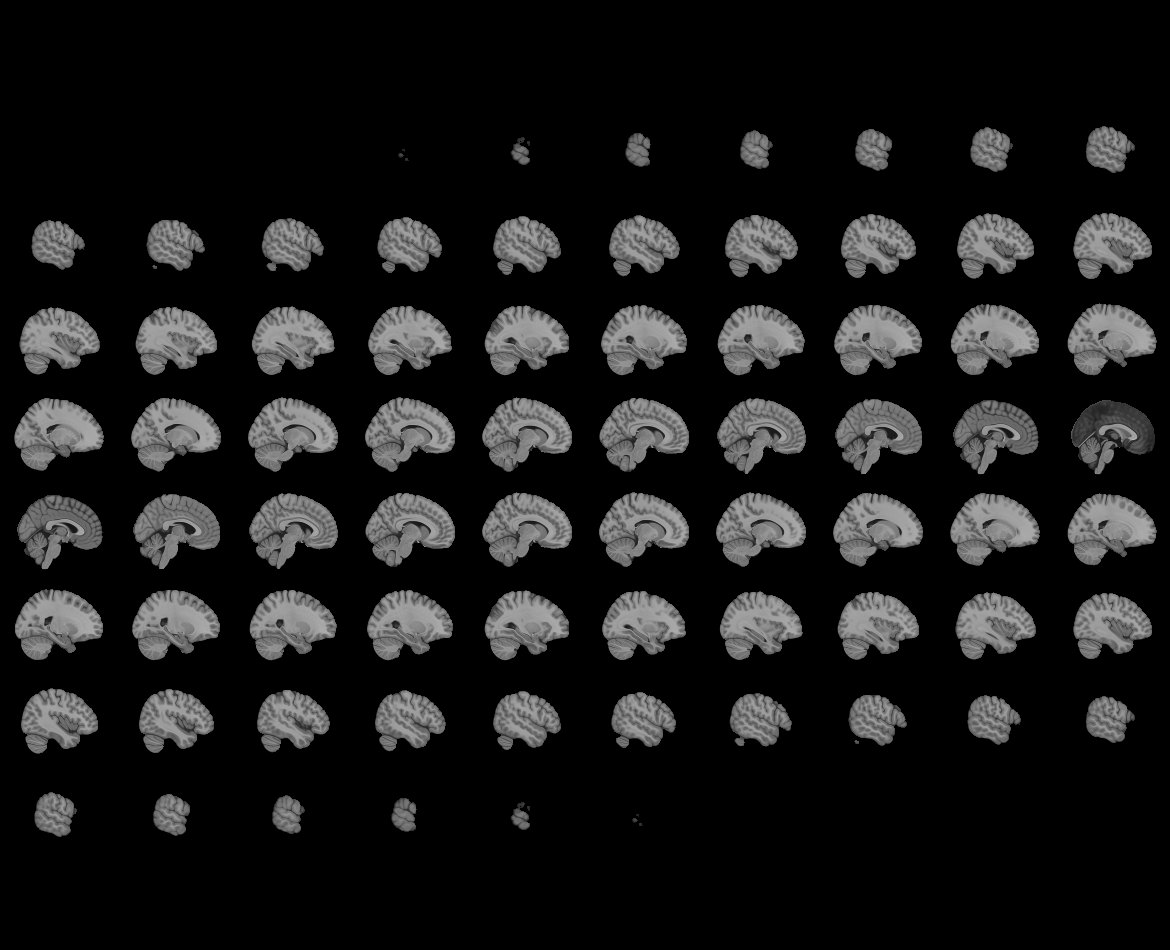
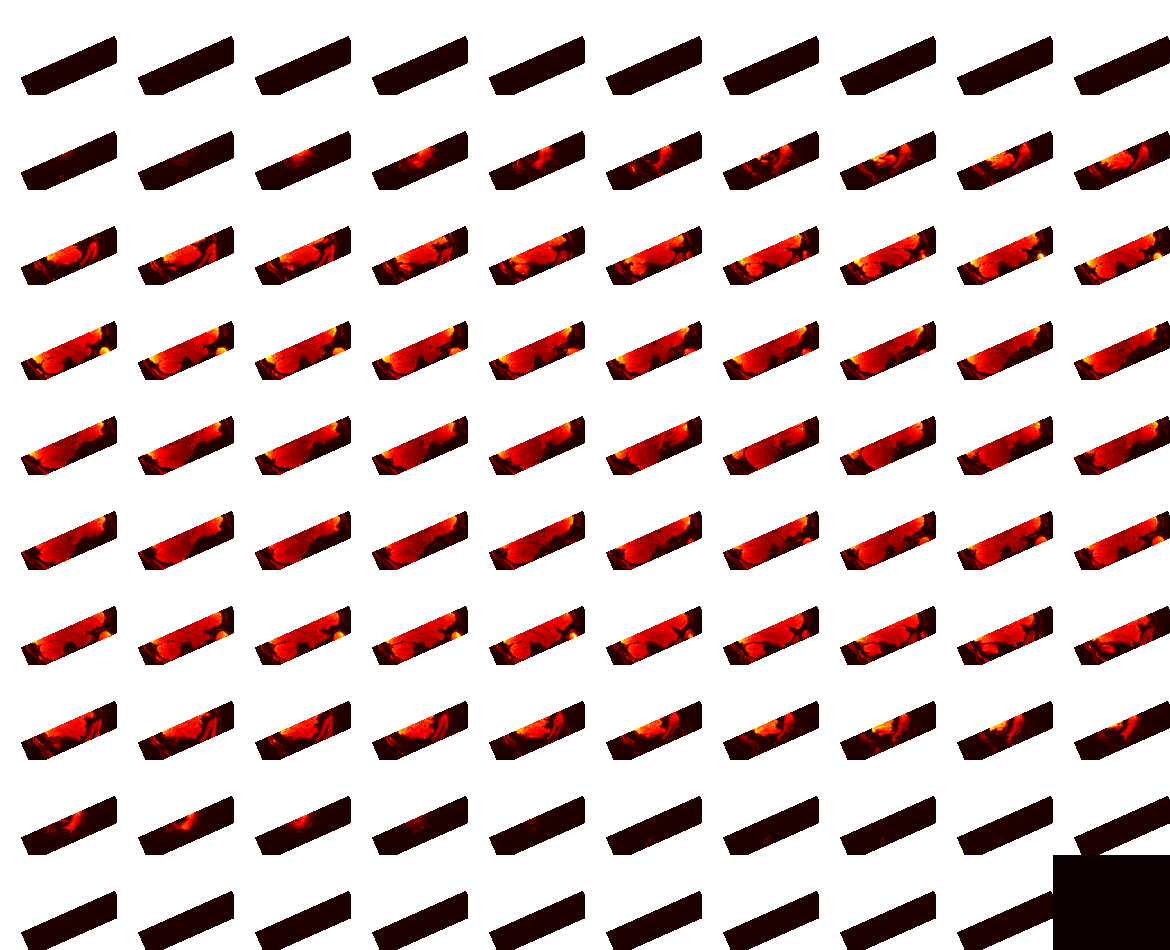

In [60]:
#Example for EDA
subject_id = '01'
run_id = '02'
# Define file paths and parameters
data_dir = 'ds002185-download'
func_file = os.path.join(data_dir, f'sub-{subject_id}', f'func/sub-{subject_id}_task-odors_run-{run_id}_bold.nii.gz')
output_dir = 'preproc'
os.makedirs(output_dir, exist_ok=True)

#View image before preprocessing
img = nib.load(func_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='Raw')


In [3]:
import os
import nibabel as nib
import numpy as np
from nilearn import plotting

subject_id = '01'
run_id = '01'

# Define file paths and parameters
data_dir = 'ds002185-download'
func_file = os.path.join(data_dir, f'sub-{subject_id}', f'func/sub-{subject_id}_task-odors_run-{run_id}_bold.nii.gz')
output_dir = 'preproc'
os.makedirs(output_dir, exist_ok=True)

# Load image before preprocessing
img = nib.load(func_file)
data = img.get_fdata()

# Check the shape of the data (4D for fMRI: X, Y, Z, Time)
print(f"Data shape: {data.shape}")

# Check the range of the data (min and max values)
data_min = np.min(data)
data_max = np.max(data)
print(f"Data range: min={data_min}, max={data_max}")

# View a middle volume of the 4D image before preprocessing
if data.ndim == 4:
    middle_volume = data[:, :, :, data.shape[3] // 2]  # Select middle time point
    img_middle = nib.Nifti1Image(middle_volume, img.affine)
    plotting.view_img(img_middle, threshold=None, title='Raw Image (Middle Volume)')


Data shape: (110, 104, 27, 415)
Data range: min=0.0, max=1919.0


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [4]:
import numpy as np

# Load the 4D fMRI data
img = nib.load(func_file)
data = img.get_fdata()

# Check the data type
print(f"Data type: {data.dtype}")

# Check if any values have decimal places by comparing to their integer counterpart
has_decimals = np.any(data % 1 != 0)
print(f"Contains decimal places: {has_decimals}")

# Optionally, count how many values have decimal places
decimal_count = np.sum(data % 1 != 0)
print(f"Number of values with decimal places: {decimal_count}")


Data type: float64
Contains decimal places: False
Number of values with decimal places: 0


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



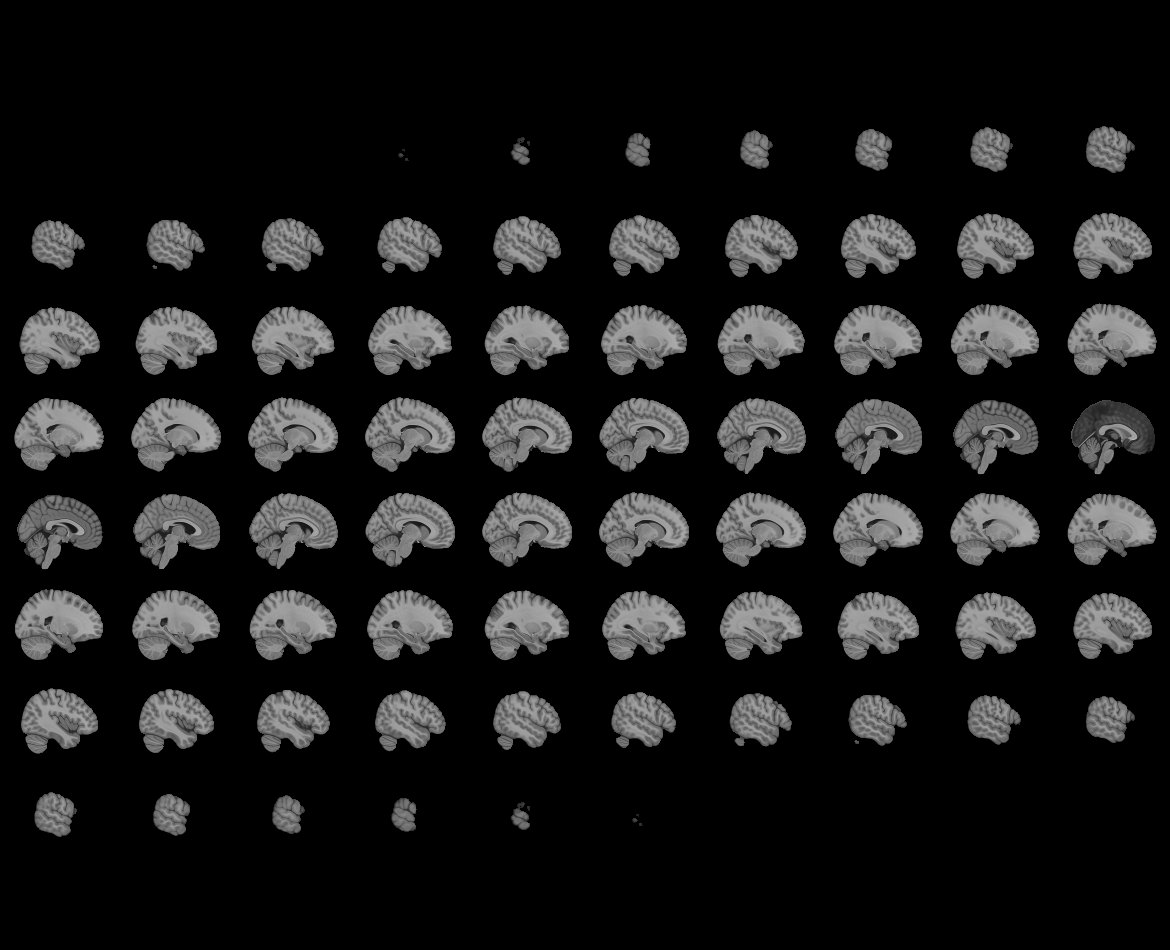
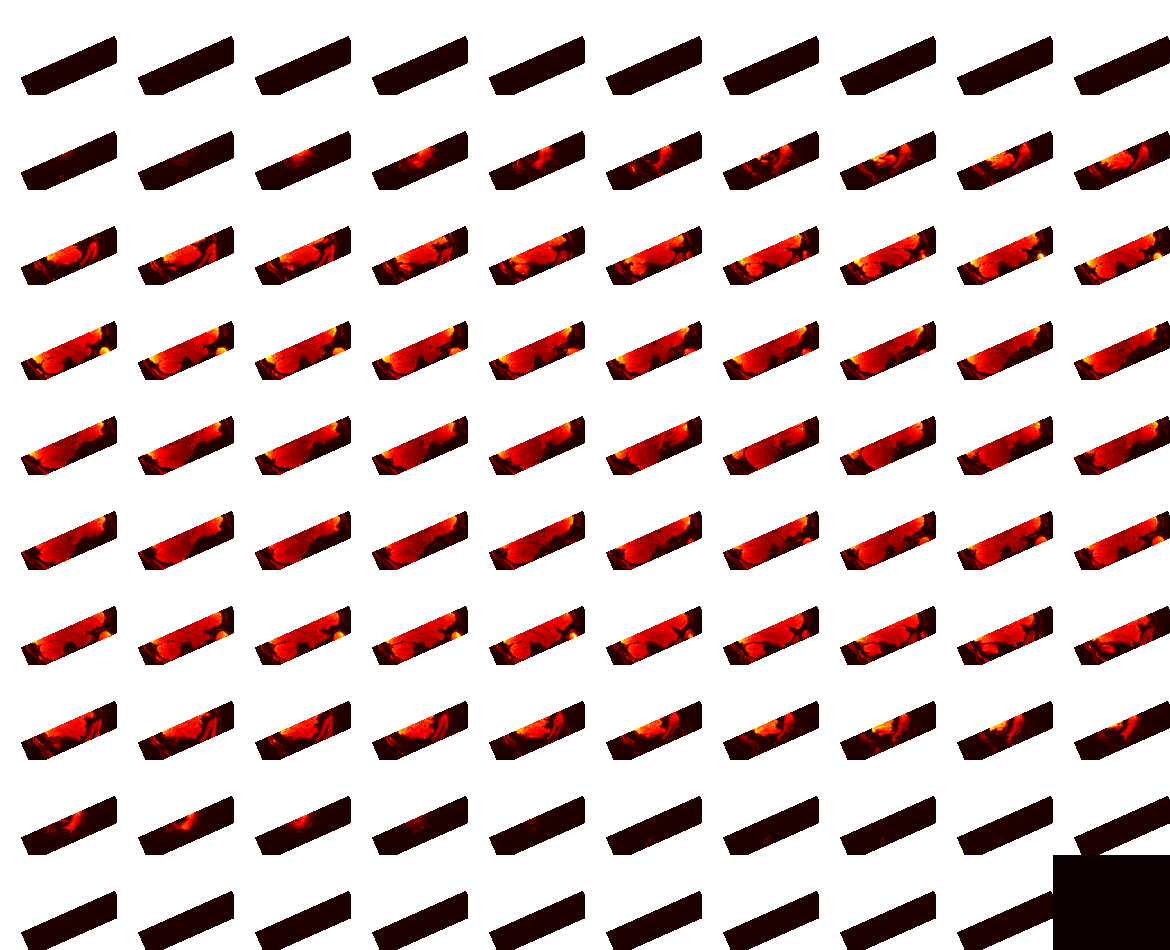

In [61]:
# Step 1: Motion Correction with MCFLIRT
motion_corrected_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_mcf.nii.gz')
mcflirt_cmd = f"mcflirt -in {func_file} -out {motion_corrected_file}"
subprocess.run(mcflirt_cmd, shell=True, check=True)
img = nib.load(motion_corrected_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='Motion Corrected')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



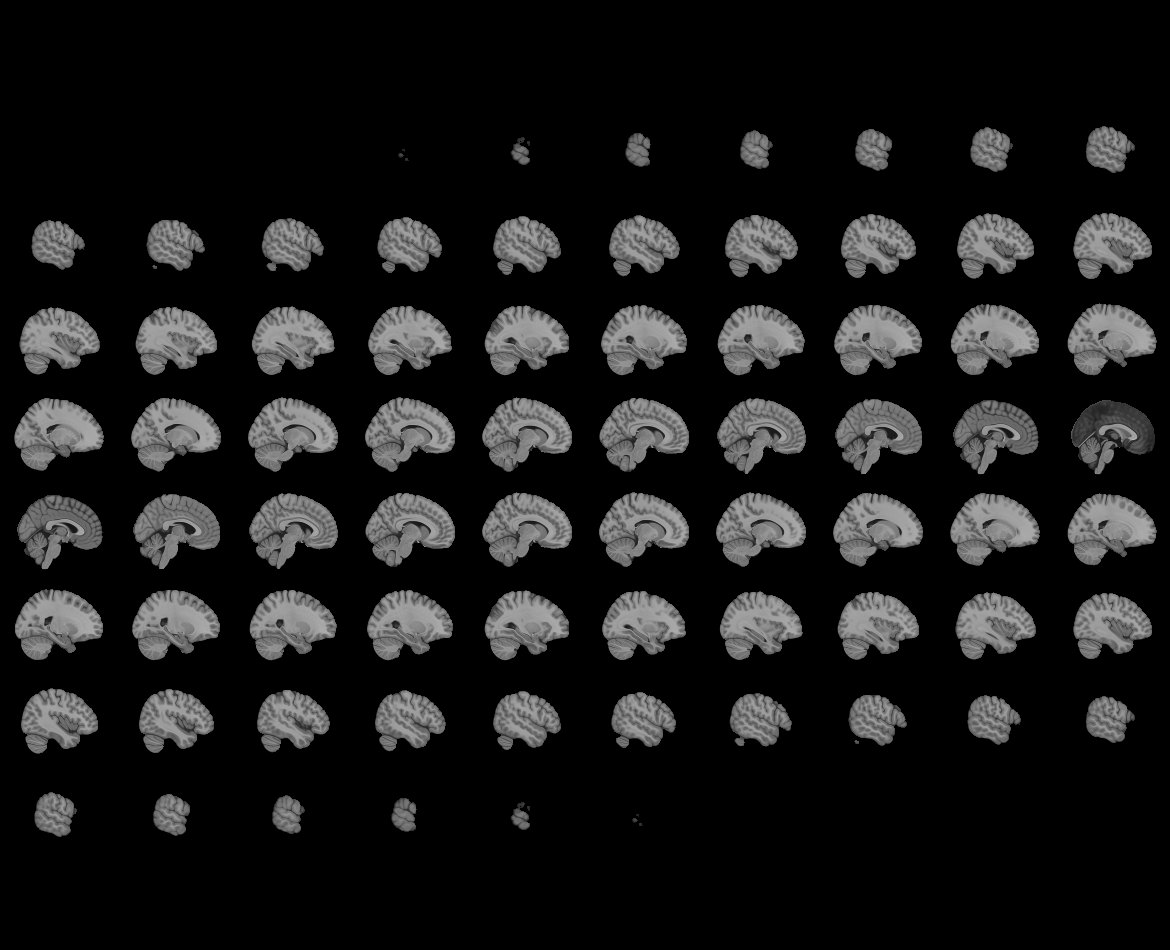
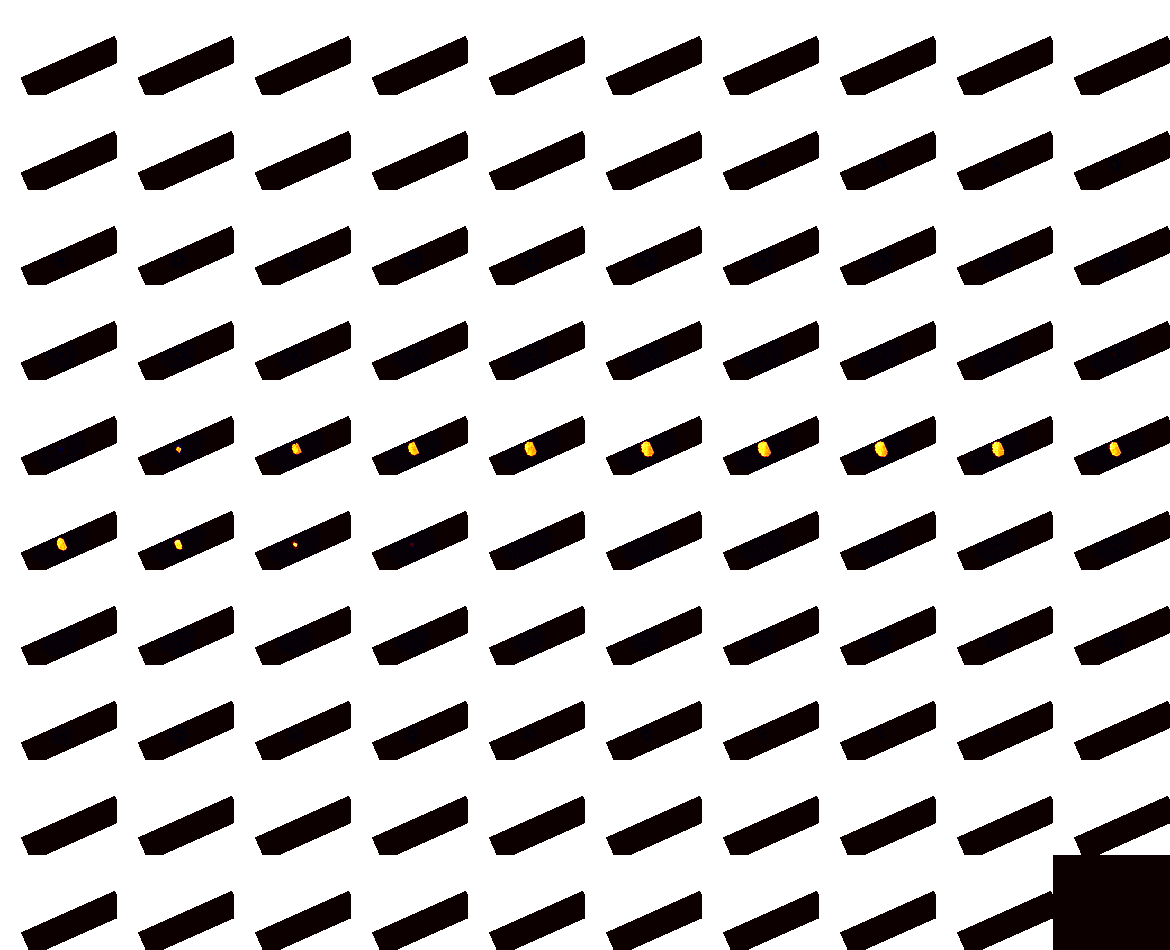

In [62]:
# Step 2: Extract a single volume from the 4D data for BET
extracted_volume_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_extracted.nii.gz')
extract_volume_cmd = f"fslroi {motion_corrected_file} {extracted_volume_file} 5 1"
subprocess.run(extract_volume_cmd, shell=True, check=True)

# Step 3: Brain Extraction
bet_output_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_brain.nii.gz')
bet_mask_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_brain_mask.nii.gz')
bet_cmd = f"bet {extracted_volume_file} {bet_output_file} -f 0.2 -g 0.2"
subprocess.run(bet_cmd, shell=True, check=True)

# Step 4: Apply brain mask to the full 4D fMRI data
masked_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_masked.nii.gz')
apply_mask_cmd = f"fslmaths {motion_corrected_file} -mas {bet_mask_file} {masked_file}"
subprocess.run(apply_mask_cmd, shell=True, check=True)
img = nib.load(masked_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='After BET')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



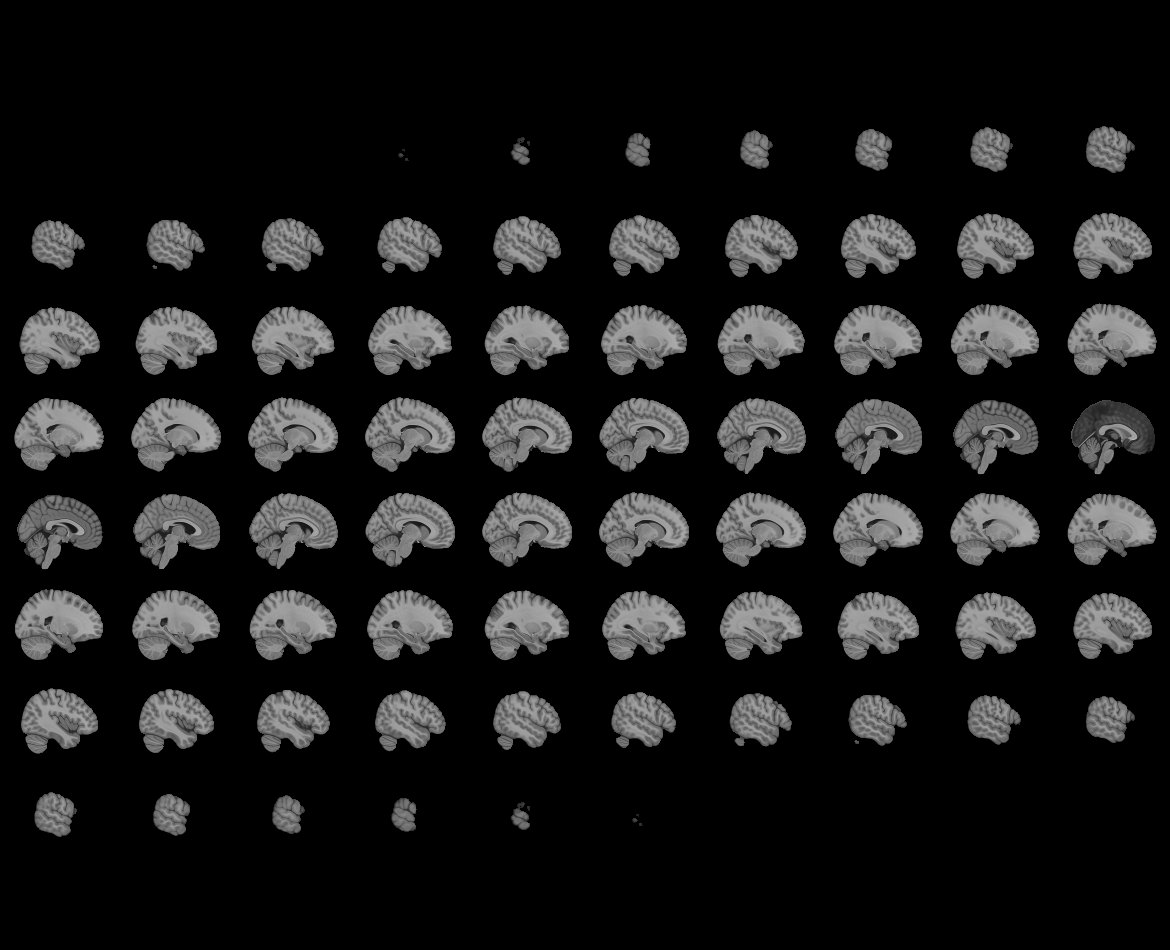
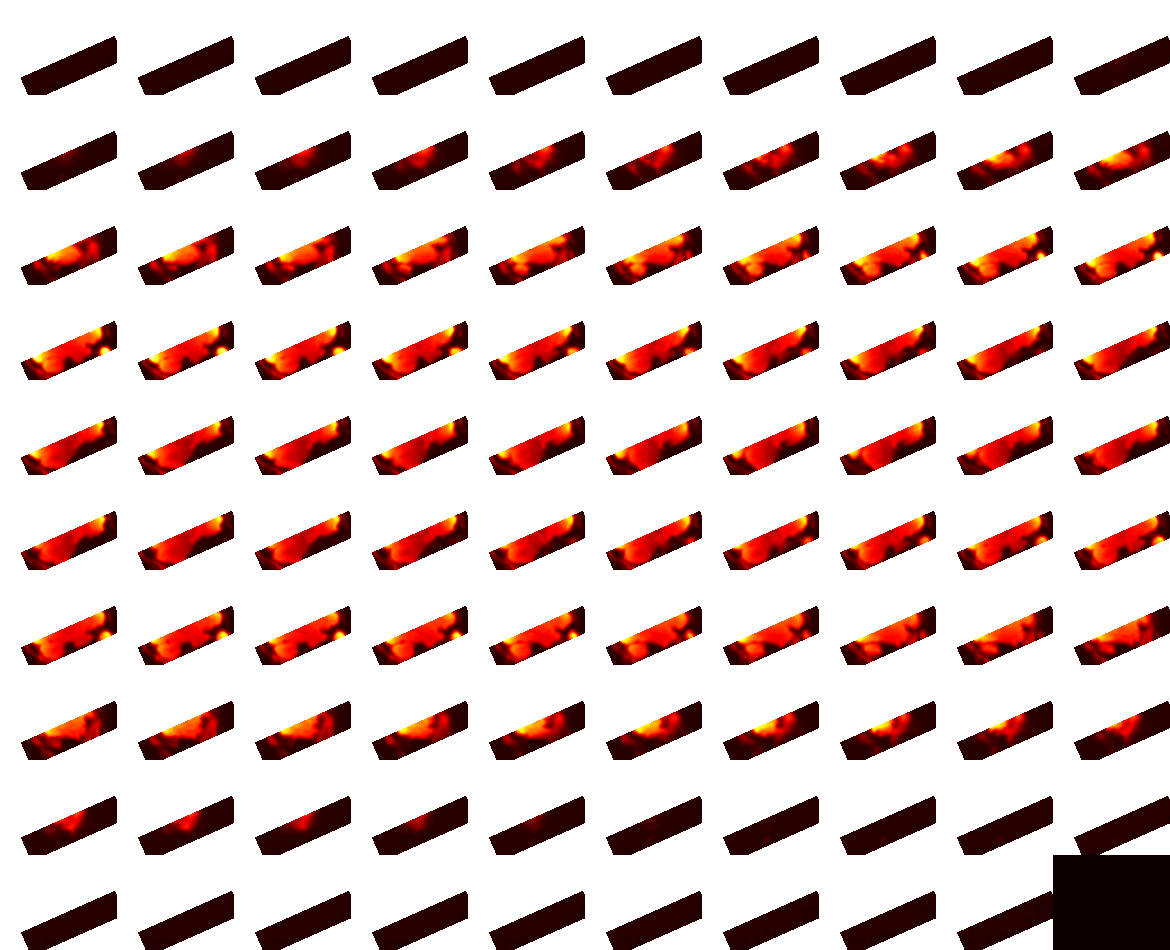

In [63]:
# Step 5: Spatial Smoothing (skipping BET due to FOV issues)
smoothed_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_smooth.nii.gz')
smooth_cmd = f"fslmaths {motion_corrected_file} -s 2.548 {smoothed_file}"
subprocess.run(smooth_cmd, shell=True, check=True)
img = nib.load(smoothed_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='Smoothed')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



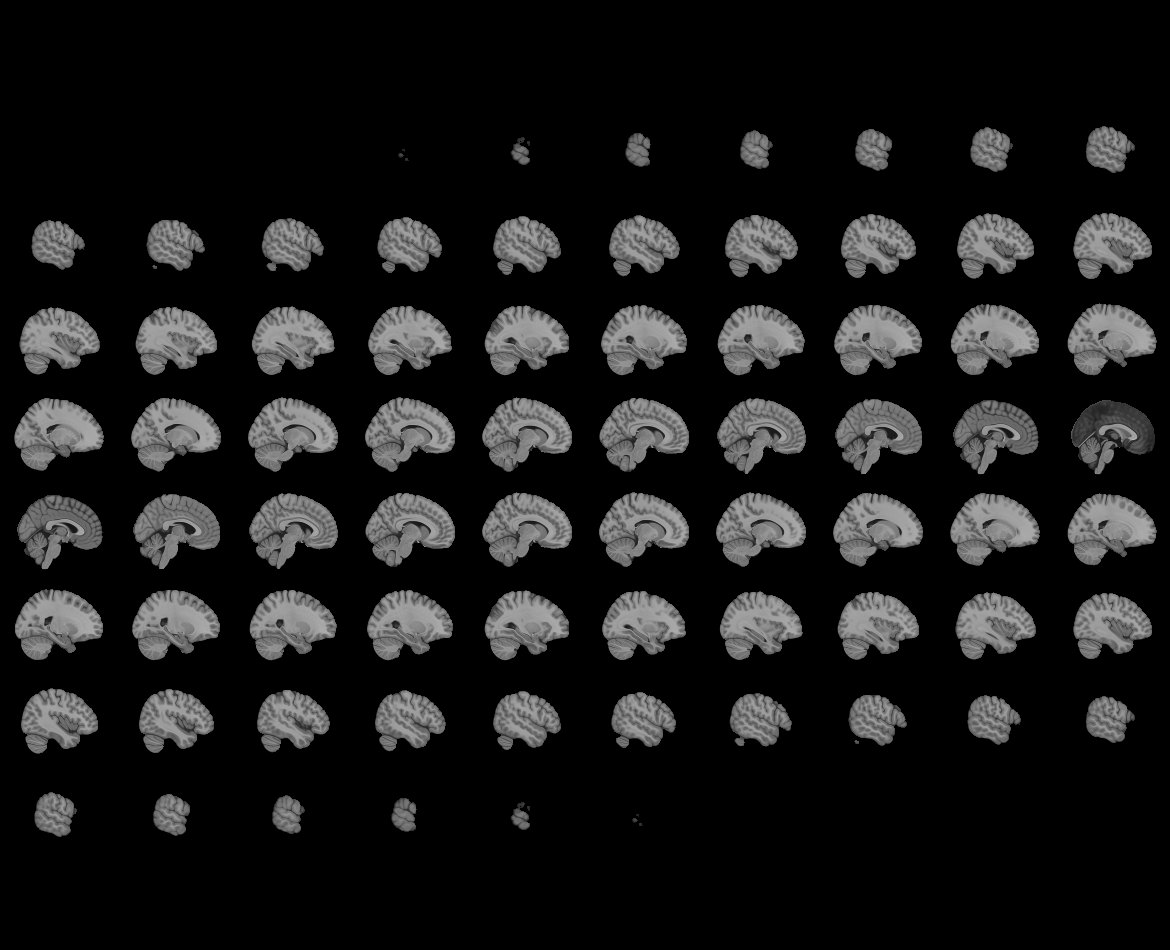
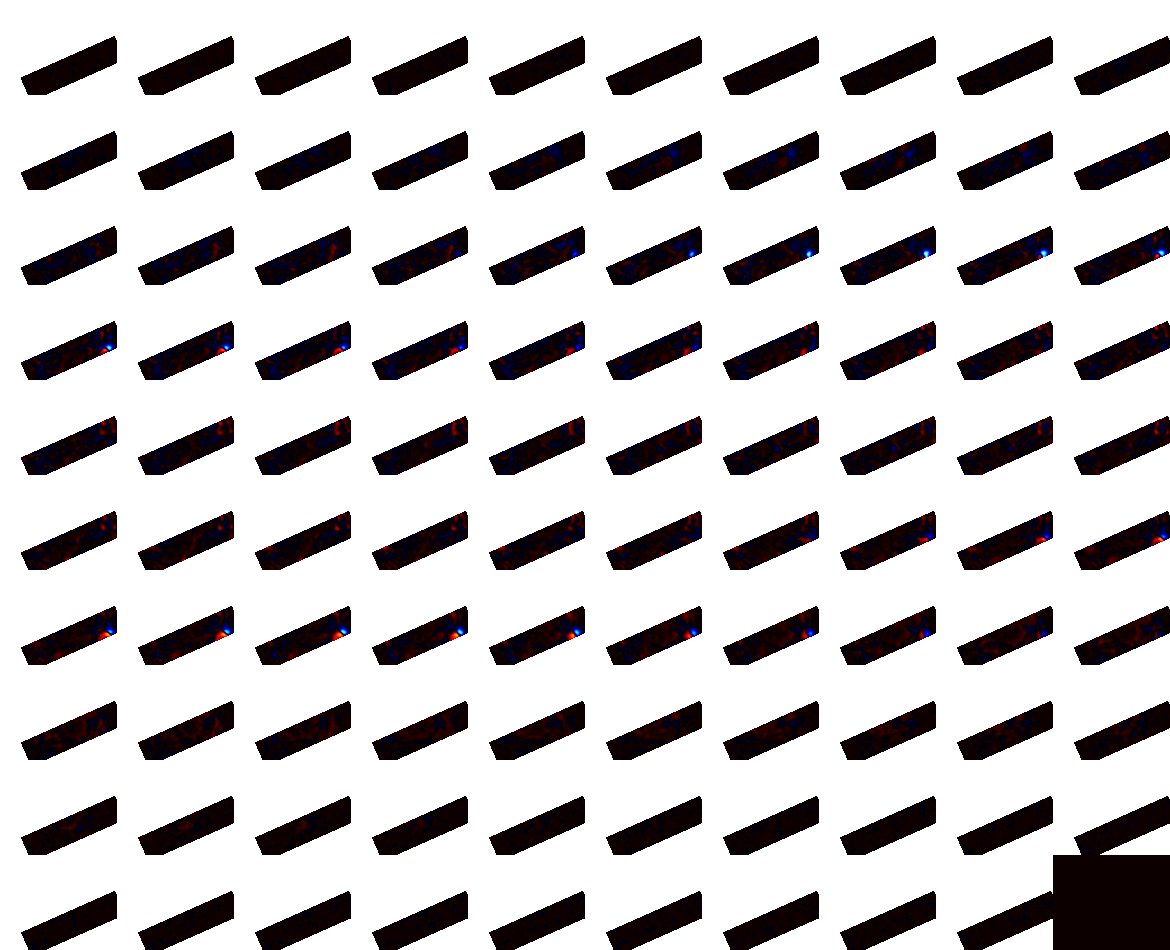

In [64]:
# Step 6: High-Pass Temporal Filtering
highpassed_file = os.path.join(output_dir, f'sub-{subject_id}_task-odors_run-{run_id}_bold_highpass.nii.gz')
highpass_cmd = f"fslmaths {smoothed_file} -bptf {125 / 2.3548} -1 {highpassed_file}"
subprocess.run(highpass_cmd, shell=True, check=True)
img = nib.load(highpassed_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='High-Temporal Pass')

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



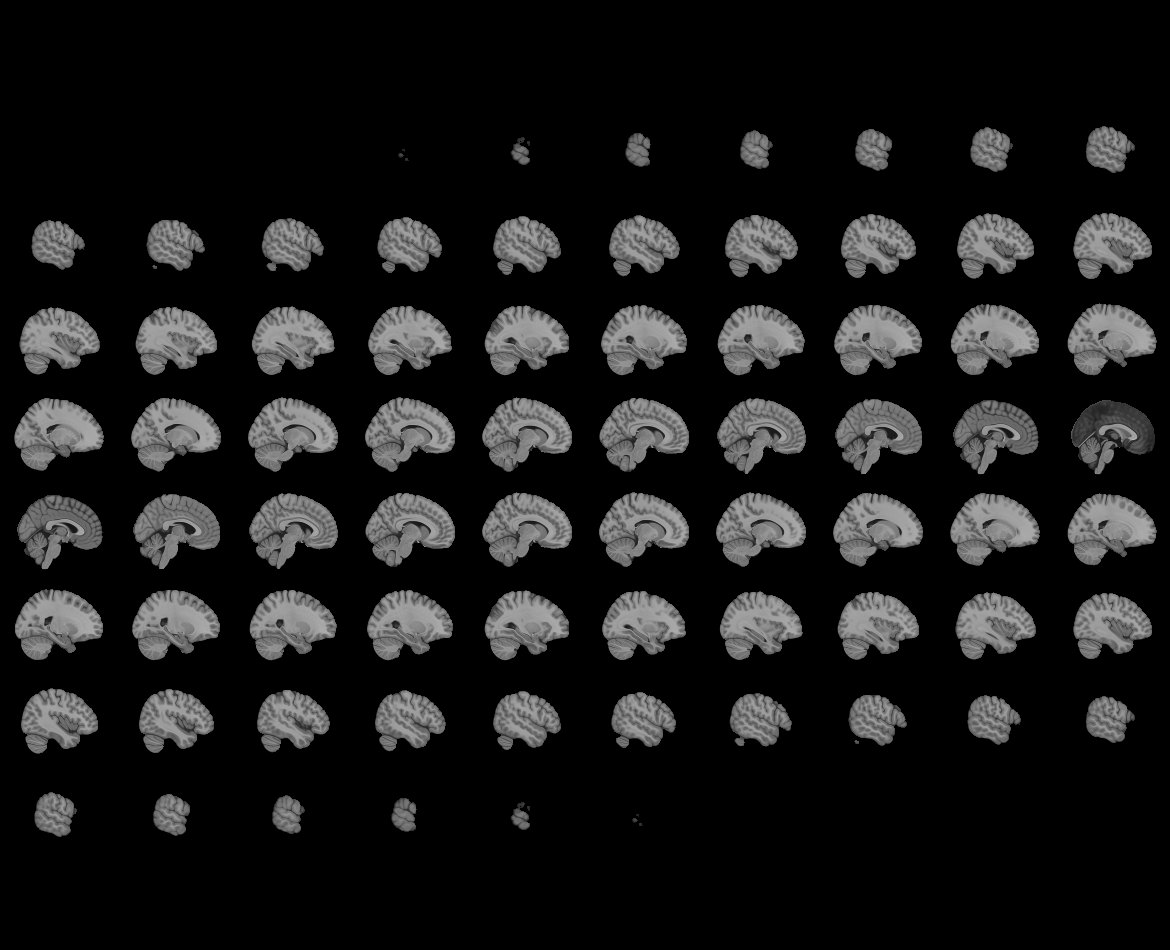
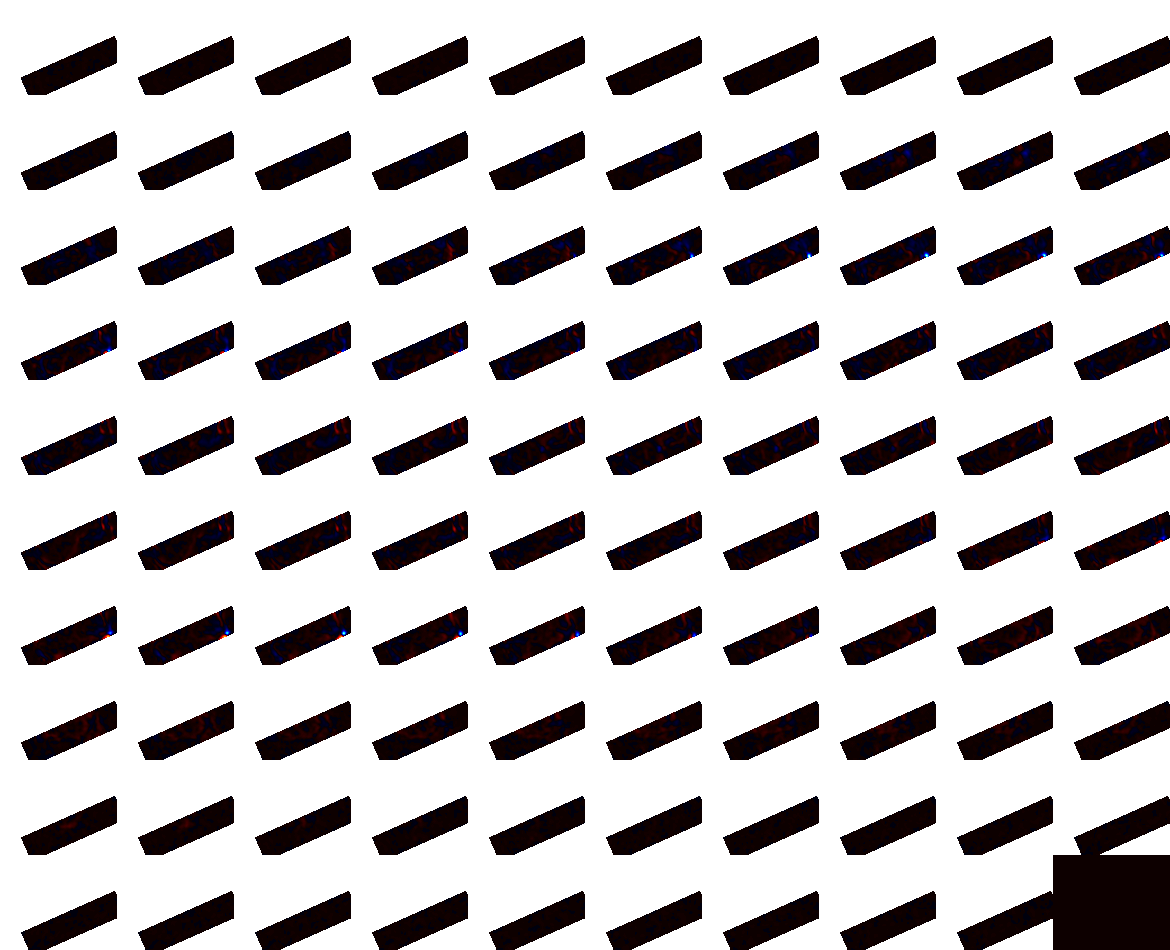

In [65]:
# Step 7: Compute Mean Image for Nonlinear Registration to MNI Template Space
mean_image_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean.nii.gz')
mean_cmd = f"fslmaths {highpassed_file} -Tmean {mean_image_file}"
subprocess.run(mean_cmd, shell=True, check=True)

# Step 8: Resample MNI Template to Match Data FOV
mni_template = '/Users/asaraog/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'
resampled_template_file = os.path.join(output_dir, f'mni_template_resampled_{subject_id}_run-{run_id}.nii.gz')
resample_cmd = f"flirt -in {mni_template} -ref {mean_image_file} -out {resampled_template_file} -usesqform > /dev/null 2>&1"
subprocess.run(resample_cmd, shell=True, check=True)

# Step 9: Nonlinear Registration to MNI Template Space
warp_field_file = os.path.join(output_dir, f'warp_field_{subject_id}_run-{run_id}.nii.gz')
jacobian_file = os.path.join(output_dir, f'jacobian_{subject_id}_run-{run_id}.nii.gz')
mni_registered_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mni.nii.gz')
nonlinear_registration_cmd = f"fnirt --in={mean_image_file} --ref={resampled_template_file} --iout={mni_registered_file} --fout={warp_field_file} --jout={jacobian_file} --interp=spline"
subprocess.run(nonlinear_registration_cmd, shell=True, check=True)

# Step 10: Apply the MNI Registration Transform to All Time Points (applied to the entire 4D dataset)
mni_registered_all_timepoints_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_preprocessed.nii.gz')
apply_transform_cmd = f"applywarp --ref={resampled_template_file} --in={highpassed_file} --warp={warp_field_file} --out={mni_registered_all_timepoints_file} --interp=spline"
subprocess.run(apply_transform_cmd, shell=True, check=True)

img = nib.load(mni_registered_all_timepoints_file)
data = img.get_fdata()
if data.ndim == 4:
    img = nib.Nifti1Image(data[:, :, :, data.shape[3] // 2], img.affine)
plotting.view_img(img, threshold=None, title='MNI Registered All Timepoints')

## Preprocessing for all subjects and all runs (putting it all together)

In [67]:
# Define base directories
data_dir = 'ds002185-download'  # Input and output directory

# Get a list of all subject IDs
subject_ids = [d for d in os.listdir(data_dir) if d.startswith('sub-')]
for subject_id in subject_ids:
    if subject_id == 'sub-21':
        print(f"Skipping {subject_id} due to missing functional files.")
        continue
    
    subject_dir = os.path.join(data_dir, subject_id, 'func')
    if not os.path.exists(subject_dir):
        print(f"Skipping {subject_id} due to missing 'func' directory.")
        continue
    
    func_files = [f for f in os.listdir(subject_dir) if f.endswith('_bold.nii.gz')]
    
    for func_file in func_files:
        # Extract run_id from the file name (assuming format sub-01_task-odors_run-01_bold.nii.gz)
        run_id = func_file.split('_')[2].split('-')[1]  # Extract '01' or '02'
        
        if subject_id == 'sub-22' and run_id == '01':
            print(f"Skipping {subject_id} run-{run_id} due to corrupt file.")
            continue
        
        func_file_path = os.path.join(subject_dir, func_file)
        output_dir = subject_dir  # Output in the same place as input

        os.makedirs(output_dir, exist_ok=True)

        # Step 1: Motion Correction
        motion_corrected_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mcf.nii.gz')
        mcflirt_cmd = f"mcflirt -in {func_file_path} -out {motion_corrected_file}"
        subprocess.run(mcflirt_cmd, shell=True, check=True)
  
        # Step 4: Spatial Smoothing
        smoothed_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_smooth.nii.gz')
        smooth_cmd = f"fslmaths {motion_corrected_file} -s 2.548 {smoothed_file}"
        subprocess.run(smooth_cmd, shell=True, check=True)

        # Step 5: High-Pass Temporal Filtering
        highpassed_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_highpass.nii.gz')
        highpass_cmd = f"fslmaths {smoothed_file} -bptf {125 / 2.3548} -1 {highpassed_file}"
        subprocess.run(highpass_cmd, shell=True, check=True)

        # Step 7: Compute Mean Image for Nonlinear Registration to MNI Template Space
        mean_image_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean.nii.gz')
        mean_cmd = f"fslmaths {highpassed_file} -Tmean {mean_image_file}"
        subprocess.run(mean_cmd, shell=True, check=True)

        # Step 8: Resample MNI Template to Match Data FOV
        mni_template = '/Users/asaraog/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'
        resampled_template_file = os.path.join(output_dir, f'mni_template_resampled_{subject_id}_run-{run_id}.nii.gz')
        resample_cmd = f"flirt -in {mni_template} -ref {mean_image_file} -out {resampled_template_file} -usesqform > /dev/null 2>&1"
        subprocess.run(resample_cmd, shell=True, check=True)

        # Step 9: Nonlinear Registration to MNI Template Space
        warp_field_file = os.path.join(output_dir, f'warp_field_{subject_id}_run-{run_id}.nii.gz')
        jacobian_file = os.path.join(output_dir, f'jacobian_{subject_id}_run-{run_id}.nii.gz')
        mni_registered_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mni.nii.gz')
        nonlinear_registration_cmd = f"fnirt --in={mean_image_file} --ref={resampled_template_file} --iout={mni_registered_file} --fout={warp_field_file} --jout={jacobian_file} --interp=spline"
        subprocess.run(nonlinear_registration_cmd, shell=True, check=True)

        # Step 10: Apply the MNI Registration Transform to All Time Points (applied to the entire 4D dataset)
        mni_registered_all_timepoints_file = os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_preprocessed.nii.gz')
        apply_transform_cmd = f"applywarp --ref={resampled_template_file} --in={highpassed_file} --warp={warp_field_file} --out={mni_registered_all_timepoints_file} --interp=spline"
        subprocess.run(apply_transform_cmd, shell=True, check=True)

        # Clean up intermediate files except warp field for later analysis
        intermediate_files = [
            motion_corrected_file,
            smoothed_file,
            highpassed_file,
            mean_image_file,
            resampled_template_file,
            mni_registered_file,
            jacobian_file,
            os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean_to_mni_template_resampled_{subject_id}_run-{run_id}.log'),
            os.path.join(output_dir, f'{subject_id}_task-odors_run-{run_id}_bold_mean_warpcoef.nii.gz')
        ]
        for file in intermediate_files:
            if os.path.isfile(file):
                os.remove(file)

        print(f"Preprocessing complete for {subject_id}_run-{run_id}! Intermediate files deleted.")


Preprocessing complete for sub-13_run-01! Intermediate files deleted.
Preprocessing complete for sub-13_run-02! Intermediate files deleted.
Preprocessing complete for sub-14_run-01! Intermediate files deleted.
Preprocessing complete for sub-14_run-02! Intermediate files deleted.
Skipping sub-22 run-01 due to corrupt file.
Preprocessing complete for sub-22_run-02! Intermediate files deleted.
Preprocessing complete for sub-15_run-02! Intermediate files deleted.
Preprocessing complete for sub-15_run-01! Intermediate files deleted.
Preprocessing complete for sub-12_run-02! Intermediate files deleted.
Preprocessing complete for sub-12_run-01! Intermediate files deleted.
Preprocessing complete for sub-08_run-01! Intermediate files deleted.
Preprocessing complete for sub-08_run-02! Intermediate files deleted.
Preprocessing complete for sub-01_run-02! Intermediate files deleted.
Preprocessing complete for sub-01_run-01! Intermediate files deleted.
Preprocessing complete for sub-06_run-02! Inte